In [1]:
# tutorial from: https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/

import re
import numpy as np 
import pandas as pd 
from pprint import pprint
from tqdm import tqdm 

import gensim 
import gensim.corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

from nltk.corpus import stopwords

import spacy

import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

from pathlib import Path

In [22]:
import pymongo

conn = 'mongodb://localhost:27017'
client = pymongo.MongoClient(conn)
db = client.visualizing_sep

sep_entries = list(db.sep_data.find( filter={},
                                     projection={'pagetext'},
                                     sort=[('title',1)]))

sep_df = pd.DataFrame(sep_entries)
sep_df.head()


,_id,pagetext
0,5e9543548d5640f2c15ad843,\n\n\nEarly modern philosophy in Europe and Gr...
1,5e953bed8d5640f2c15ad69e,\n\n18th-century British aesthetics addressed ...
2,5e953bf18d5640f2c15ad69f,\n\nFrench philosophers of the Ancien Régime w...
3,5e953bf68d5640f2c15ad6a0,\n\n\nThe philosophical discipline of aestheti...
4,5e953b948d5640f2c15ad68b,"\n\n\nIn Germany, the eighteenth century was t..."


In [23]:
stop_words = stopwords.words('english')
stop_words.extend (['from', 'subject','re','edu','use'])

In [4]:
# 6. Import Newsgroups Data

df = pd.read_json('https://raw.githubusercontent.com/selva86/datasets/master/newsgroups.json')
print(df.target_names.unique())
df.head()

['rec.autos' 'comp.sys.mac.hardware' 'comp.graphics' 'sci.space'
 'talk.politics.guns' 'sci.med' 'comp.sys.ibm.pc.hardware'
 'comp.os.ms-windows.misc' 'rec.motorcycles' 'talk.religion.misc'
 'misc.forsale' 'alt.atheism' 'sci.electronics' 'comp.windows.x'
 'rec.sport.hockey' 'rec.sport.baseball' 'soc.religion.christian'
 'talk.politics.mideast' 'talk.politics.misc' 'sci.crypt']


,content,target,target_names
0,From: lerxst@wam.umd.edu (where's my thing)\nS...,7,rec.autos
1,From: guykuo@carson.u.washington.edu (Guy Kuo)...,4,comp.sys.mac.hardware
2,From: twillis@ec.ecn.purdue.edu (Thomas E Will...,4,comp.sys.mac.hardware
3,From: jgreen@amber (Joe Green)\nSubject: Re: W...,1,comp.graphics
4,From: jcm@head-cfa.harvard.edu (Jonathan McDow...,14,sci.space


In [24]:
# 7. Remove emails and newline characters

# data = df.content.values.tolist()
sep_data = sep_df.pagetext.values.tolist()
# print(sep_data[:1])
# # # print(data[:1])
# data = [re.sub('\S*@\S*\s?', '', sent) for sent in data]

# data = [re.sub('\s+',' ',sent) for sent in data]

sep_data = [sep_article.strip() for sep_article in sep_data]
sep_data = [re.sub('\s+',' ', sep_article) for sep_article in sep_data]

# data = [re.sub('\'','',sent) for sent in data]
sep_data = [re.sub('\'','',sep_article) for sep_article in sep_data]

pprint(sep_data[2:3])

of taste as a combination of three '
 'elements: sentiment, reason, and a knowledge of rules. Simultaneously, they '
 'distanced themselves from both the refined world of salons that had promoted '
 'their careers and the academics who had developed theories of beauty. Even '
 'Montesquieu criticized salons as having a feminizing influence that '
 'discouraged serious scholarship. Meanwhile, Voltaire describes scholars as '
 'myopic and dust-covered in his poem The Temple of Taste (1733). The majority '
 'of Enlightenment philosophers saw themselves as erudite, serious thinkers '
 'who also lived in society. In terms of taste, they set themselves off as a '
 'caste of professional critics who claimed the right to make artistic '
 'judgments that were more authoritative than the potentially wayward '
 'preferences of the general public. Voltaire describes good taste as a '
 'combination of sentiment and erudition. In his article “Taste” in the '
 'Encyclopédie, he gives the example of a

In [25]:
# 8. Tokenize words and Clean-up text

def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))

# data_words = list(sent_to_words(data))
sep_data_words = list(sent_to_words(sep_data))

# pprint(data_words[:2])
pprint(sep_data_words[:2])

udden',
  'protuberance',
  'and',
  'lines',
  'that',
  'cross',
  'each',
  'other',
  'in',
  'sudden',
  'and',
  'broken',
  'manner',
  'price',
  'because',
  'the',
  'play',
  'of',
  'form',
  'color',
  'light',
  'and',
  'shadow',
  'afforded',
  'by',
  'such',
  'objects',
  'renders',
  'them',
  'ideal',
  'subjects',
  'for',
  'painting',
  'and',
  'drawing',
  'gilpin',
  'referred',
  'to',
  'them',
  'as',
  'picturesque',
  'gilpin',
  'by',
  'the',
  'end',
  'of',
  'the',
  'century',
  'the',
  'picturesque',
  'came',
  'to',
  'be',
  'regarded',
  'widely',
  'as',
  'occupying',
  'the',
  'position',
  'vacated',
  'by',
  'the',
  'novel',
  'that',
  'of',
  'third',
  'perfection',
  'of',
  'taste',
  'association',
  'theories',
  'gerard',
  'alexander',
  'gerard',
  'theory',
  'of',
  'taste',
  'advanced',
  'in',
  'his',
  'essay',
  'on',
  'taste',
  'is',
  'an',
  'attempt',
  'to',
  'mediate',
  'or',
  'perhaps',
  'to',
  'transce

In [26]:
# 9. Creating Bigram and Trigram Models
# bigram = gensim.models.Phrases(sep_data_words, min_count=5, threshold=100)
# trigram = gensim.models.Phrases(bigram[sep_data_words], threshold=100)
bigram = gensim.models.Phrases(sep_data_words, min_count=5, threshold=100)
# trigram = gensim.models.Phrases(bigram[sep_data_words], threshold=100)

bigram_mod = gensim.models.phrases.Phraser(bigram)
# trigram_mod = gensim.models.phrases.Phraser(trigram)

# print(trigram_mod[bigram_mod[data_words[0]]])
# print(trigram_mod[bigram_mod[sep_data_words[0]]])

In [27]:
# 10. Remove Stopwords, Make Bigrams and Lemmatize

def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

# def make_trigrams(texts):
#     return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_posttags=['NOUN', 'ADJ','VERB','ADV']):
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent))
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_posttags])
    
    return texts_out 

# data_words_nostops = remove_stopwords(data_words)
# data_words_bigrams = make_bigrams(data_words_nostops)

sep_data_words_nostops = remove_stopwords(sep_data_words)
sep_data_words_bigrams = make_bigrams(sep_data_words_nostops)

nlp = spacy.load('en_core_web_sm', disable =['parser','ner'])

# data_lemmatized = lemmatization(data_words_bigrams, allowed_posttags=['NOUN', 'ADJ', 'VERB', 'ADV'])
sep_data_lemmatized = lemmatization(sep_data_words_bigrams, allowed_posttags=['NOUN', 'ADJ', 'VERB', 'ADV'])

# pprint(len(data_lemmatized))
pprint(len(sep_data_lemmatized))


1680


In [28]:
# 11. Create the Dictionary and Corpus needed for Topic Modeling

# id2word = gensim.corpora.Dictionary(data_lemmatized)
id2word = gensim.corpora.Dictionary(sep_data_lemmatized)

# texts = data_lemmatized
texts = sep_data_lemmatized

corpus = [id2word.doc2bow(text) for text in texts]

# [ [ (id2word[id],freq) for id, freq in cp] for cp in corpus[:1]]

In [27]:
# 12. Building the Topic Model

lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=22, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [28]:
# 13. View the topics in LDA model

# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(19,
  '0.000*"bidaku" + 0.000*"bickerton" + 0.000*"chomskyanism" + '
  '0.000*"cerebellar" + 0.000*"cartilege" + 0.000*"broca" + 0.000*"bridged" + '
  '0.000*"bleat" + 0.000*"clahsen" + 0.000*"babbling"'),
 (3,
  '0.066*"art" + 0.053*"aesthetic" + 0.038*"work" + 0.020*"music" + '
  '0.019*"beauty" + 0.016*"object" + 0.015*"dance" + 0.011*"experience" + '
  '0.010*"beautiful" + 0.009*"performance"'),
 (7,
  '0.030*"causal" + 0.030*"mental" + 0.025*"physical" + 0.024*"state" + '
  '0.024*"cause" + 0.023*"explanation" + 0.016*"event" + 0.014*"property" + '
  '0.013*"brain" + 0.011*"argument"'),
 (0,
  '0.022*"thing" + 0.020*"form" + 0.016*"substance" + 0.013*"category" + '
  '0.011*"universal" + 0.011*"term" + 0.011*"nature" + 0.010*"real" + '
  '0.009*"reality" + 0.009*"object"'),
 (14,
  '0.015*"selection" + 0.011*"level" + 0.010*"specie" + 0.009*"organism" + '
  '0.009*"genetic" + 0.008*"human" + 0.008*"population" + 0.008*"biological" + '
  '0.008*"gene" + 0.007*"trait"'),
 (5,
  '0

In [29]:
# 14. Compute Model Perplexity and Coherence Score

# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=sep_data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -8.534089048334774

Coherence Score:  0.4377793139266146


In [34]:
# 15. Visualize the topics-keywords
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model,corpus,id2word)

vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
12     0.310693  0.189742       1        1  25.079853
9      0.318704 -0.027048       2        1  18.291174
10     0.279536 -0.102600       3        1  12.789779
13     0.209532  0.257029       4        1   9.984110
11     0.199096 -0.260548       5        1   8.499678
18     0.101253 -0.060145       6        1   4.616012
8      0.093283 -0.130299       7        1   4.271560
19     0.059757  0.060961       8        1   3.778192
5     -0.067481  0.010406       9        1   1.713308
20    -0.073350 -0.019446      10        1   1.607175
21    -0.104069 -0.002843      11        1   1.138008
16    -0.108899  0.004194      12        1   1.079860
4     -0.097977 -0.003353      13        1   1.048631
15    -0.103256  0.022734      14        1   0.930672
7     -0.115385  0.004744      15        1   0.839904
14    -0.112504  0.008654      16        1   0.823540
1     -0.113230  0.018808      17        1   0.749621
17    -0.129654  0.005517      18        1   0.698477
3     -0.126906  0.005569      19        1   0.664757
0     -0.141568  0.006548      20        1   0.496607
6     -0.141732  0.005128      21        1   0.480025
2     -0.135845  0.006246      22        1   0.419064, topic_info=     Category         Freq        Term        Total  loglift  logprob
47    Default  1751.000000  philosophy  1751.000000  30.0000  30.0000
59    Default  1319.000000      theory  1319.000000  29.0000  29.0000
725   Default   571.000000       logic   571.000000  28.0000  28.0000
190   Default   482.000000       moral   482.000000  27.0000  27.0000
75    Default   604.000000    question   604.000000  26.0000  26.0000
...       ...          ...         ...          ...      ...      ...
2934  Topic22     0.025933      retain     0.998902   1.8238  -9.7734
2446  Topic22     0.025933        bind     0.998902   1.8238  -9.7734
3821  Topic22     0.025933       sheer     0.998901   1.8238  -9.7734
6833  Topic22     0.025933      worthy     0.998901   1.8238  -9.7734
895   Topic22     0.025938   principle   247.680969  -3.6893  -9.7733

[856 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
1335     11  0.781450   abandon
398       9  0.950064   ability
1873      7  0.983870      able
517       7  0.966553  absolute
555      13  0.961830  abstract
...     ...       ...       ...
471       1  0.691894   writing
471       4  0.306410   writing
981      12  0.960352     wrong
245       1  0.996635      year
396       9  0.948425     yield

[951 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[13, 10, 11, 14, 12, 19, 9, 20, 6, 21, 22, 17, 5, 16, 8, 15, 2, 18, 4, 1, 7, 3])

In [29]:
# # 16. Building LDA Mallet Model


# mallet_path =  path_to_files = Path.cwd() / 'mallet-2.0.8/bin/mallet'
mallet_path = r"C:\mallet\bin\mallet"
mallet_path = str(mallet_path)
print(mallet_path)

lda_mallet = gensim.models.wrappers.LdaMallet(mallet_path, 
                                            corpus=corpus, 
                                            num_topics=22, 
                                            id2word=id2word)

# #showtopics 

pprint(lda_mallet.show_topics(formatted=False))

coherence_model_ldamallet = CoherenceModel(model=lda_mallet, texts=sep_data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)

C:\mallet\bin\mallet
[(14,
  [('language', 0.030968372648768037),
   ('meaning', 0.016564983616054456),
   ('word', 0.014975469341202455),
   ('semantic', 0.014435975885728768),
   ('sentence', 0.012828357803646107),
   ('expression', 0.011199015152886653),
   ('linguistic', 0.010960044897441932),
   ('term', 0.009725365244310879),
   ('speaker', 0.008508789398410486),
   ('context', 0.007592736752539059)]),
 (12,
  [('form', 0.014601302557292223),
   ('thing', 0.01295332331013318),
   ('soul', 0.010293849493736646),
   ('human', 0.008370633629098016),
   ('intellect', 0.008349990882787046),
   ('matter', 0.008291503101572633),
   ('term', 0.007919933667975188),
   ('aristotle', 0.007789196274672382),
   ('work', 0.007544923776659247),
   ('substance', 0.007317853567238585)]),
 (4,
  [('art', 0.03833651378561558),
   ('aesthetic', 0.029170230966638153),
   ('work', 0.023623083503323025),
   ('beauty', 0.01404224517996973),
   ('object', 0.013680331644403501),
   ('experience', 0.012430


Coherence Score:  0.33577738973310717


In [31]:
# 17. How to find the optimal number of topics for LDA?

def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in tqdm(range(start, limit, step), desc='Processing'):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        # model = gensim.models.ldamodel.LdaModel(corpus=corpus,
        #                                    id2word=id2word,
        #                                    num_topics=num_topics, 
        #                                    random_state=100,
        #                                    update_every=1,
        #                                    chunksize=100,
        #                                    passes=10,
        #                                    alpha='auto',
        #                                    per_word_topics=True)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [32]:
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=sep_data_lemmatized, start=16, limit=60, step=4)

Processing: 100%|██████████| 11/11 [1:44:12<00:00, 568.42s/it]


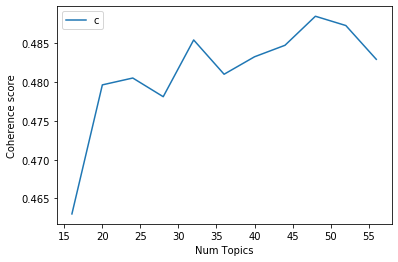

In [33]:
# Show graph
limit=60; start=16; step=4;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [34]:
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

    #32 topics

Num Topics = 16  has Coherence Value of 0.463
Num Topics = 20  has Coherence Value of 0.4796
Num Topics = 24  has Coherence Value of 0.4805
Num Topics = 28  has Coherence Value of 0.4781
Num Topics = 32  has Coherence Value of 0.4854
Num Topics = 36  has Coherence Value of 0.481
Num Topics = 40  has Coherence Value of 0.4833
Num Topics = 44  has Coherence Value of 0.4847
Num Topics = 48  has Coherence Value of 0.4885
Num Topics = 52  has Coherence Value of 0.4873
Num Topics = 56  has Coherence Value of 0.4829
